In [1]:
pip install torchtext==0.8.0

In [2]:
import torch
import torch.nn as nn
import tqdm
import numpy as np
import torch.optim as optim
import spacy
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score
import matplotlib.pyplot as plt

In [3]:
torch.cuda.get_device_name()

'Tesla T4'

In [4]:
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [5]:
spacy_ger = spacy.load("de")
spacy_eng = spacy.load("en")

In [6]:
def tokenize_ger(text):
    return [t.text for t in spacy_ger.tokenizer(text)]

def tokenize_eng(text):
    return [t.text for t in spacy_eng.tokenizer(text)]

In [7]:
german = Field(tokenize=tokenize_ger, lower=True, init_token="<sos>", eos_token="<eos>")
english = Field(tokenize=tokenize_eng, lower=True, init_token="<sos>", eos_token="<eos>")

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [8]:
train_data, valid_data, test_data = Multi30k.splits(exts=(".de", ".en"), fields=(german, english))

/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [9]:
for data in train_data:
    print(vars(data)["src"])
    print(vars(data)["trg"])
    break

['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


In [10]:
german.build_vocab(train_data, max_size=10000, min_freq=2)
english.build_vocab(train_data, max_size=10000, min_freq=2)

In [11]:
class Transformer(nn.Module):
    def __init__(self, embedding_size, src_vocab_size, trg_vocab_size, src_pad_idx, num_heads, num_encoder_layers,
                 num_decoder_layers, forward_expansion, p, max_len, device):
        super(Transformer, self).__init__()

        self.src_pad_idx = src_pad_idx
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_positional_embedding = nn.Embedding(max_len, embedding_size)

        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_positional_embedding = nn.Embedding(max_len, embedding_size)

        self.dropout = nn.Dropout(p)
        self.device = device

        self.transformer = nn.Transformer(embedding_size, num_heads, num_encoder_layers, num_decoder_layers, 
                                          forward_expansion, dropout=p)
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
    
    def build_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx
        return src_mask.to(self.device)

    def forward(self, src, trg):
        src_seq_len, N = src.shape
        trg_seq_len, N = trg.shape
        src_positions = (torch.arange(0, src_seq_len).unsqueeze(1).expand(src_seq_len, N).to(self.device))
        trg_positions = (torch.arange(0, trg_seq_len).unsqueeze(1).expand(trg_seq_len, N).to(self.device))
        
        src_embedding = self.dropout((self.src_word_embedding(src) + self.src_positional_embedding(src_positions)))
        trg_embedding = self.dropout((self.trg_word_embedding(trg) + self.trg_positional_embedding(trg_positions)))
        
        src_mask = self.build_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_len).to(self.device)

        x = self.transformer(src_embedding, trg_embedding, src_key_padding_mask=src_mask, tgt_mask=trg_mask)
        x = self.fc_out(x)

        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 16
lr = 3e-4
batch_size = 32
src_vocab_size = len(german.vocab)
trg_vocab_size = len(english.vocab)
embedding_size = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
p = 0.10
max_len = 100
forward_expansion = 4
src_pad_idx = english.vocab.stoi["<pad>"]

In [15]:
device

device(type='cuda')

In [16]:
train_batches, valid_batches, test_batches = BucketIterator.splits((train_data, valid_data, test_data),
                                                                   batch_size=batch_size, sort_within_batch=True,
                                                                   sort_key=lambda x: len(x.src),
                                                                   device=device)

/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [17]:
for batch in train_batches:
    ger = batch.src
    eng = batch.trg
    print(ger.shape)
    print(eng.shape)
    break

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


torch.Size([13, 32])
torch.Size([18, 32])


In [18]:
net = Transformer(embedding_size, src_vocab_size, trg_vocab_size, src_pad_idx, num_heads, num_encoder_layers, 
                  num_decoder_layers, forward_expansion, p, max_len, device).to(device)

In [19]:
net

Transformer(
  (src_word_embedding): Embedding(7855, 512)
  (src_positional_embedding): Embedding(100, 512)
  (trg_word_embedding): Embedding(5893, 512)
  (trg_positional_embedding): Embedding(100, 512)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=4, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=4, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEnc

In [20]:
opt = optim.Adam(net.parameters(), lr)
pad_idx = english.vocab.stoi["<pad>"]
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [21]:
def translate(net, sentence, german, english, device, max_len=50):
    if type(sentence) == str:
        tokens = [t.text.lower() for t in spacy_ger(sentence)]
    else:
        tokens = [t.lower() for t in sentence]

    tokens.insert(0, "<sos>")
    tokens.append("<eos>")

    text2idx = []
    for t in tokens:
        text2idx.append(german.vocab.stoi[t])
    
    text_tensor = torch.LongTensor(text2idx)
    text_tensor = text_tensor.unsqueeze(1).to(device)

    output = [english.vocab.stoi["<sos>"]]
    for _ in range(max_len):
        trg_tensor = torch.LongTensor(output).unsqueeze(1).to(device)

        with torch.no_grad():
            p = net(text_tensor, trg_tensor)

        pred = p.argmax(2)[-1, :].item()
        output.append(pred)
        if pred == english.vocab.stoi["<eos>"]:
            break

    output_text = [english.vocab.itos[idx] for idx in output]
    
    return output_text[1:]

In [22]:
def bleu(data, net, german, english, device):
    targets = []
    outputs = []

    for d in data:
        src = vars(d)["src"]
        trg = vars(d)["trg"]

        prediction = translate(net, src, german, english, device)
        prediction = prediction[:-1]  

        targets.append([trg])
        outputs.append(prediction)
       
    return bleu_score(outputs, targets)

In [23]:
def save_checkpoint(net, opt, losses, filename):
    check_point = {"net_dict": net.state_dict(), "opt_dict": opt.state_dict(), "losses": losses}
    torch.save(check_point, filename)
    print("Checkpoint Saved!")

def load_checkpoint(net, opt, filename):
    check_point = torch.load(filename)
    net.load_state_dict(check_point["net_dict"])
    opt.load_state_dict(check_point["opt_dict"])
    losses = check_point["losses"]
    print("Checkpoint Loaded!")

In [24]:
t = [[['that', 'is', 'a', 'plane', 'and', 'not', 'a', 'bird']]]
o = [['that', 'is', 'a', 'plane', 'and', 'not', 'a', 'dog']]
bleu_score(o, t)

0.8408964276313782

In [25]:
text = "ein boot mit mehreren männern darauf wird von einem großen pferdegespann ans ufer gezogen"
english_translation = "a boat with several men on it is being pulled ashore by a large team of horses"

In [26]:
losses = []

In [27]:
for epoch in range(epochs):
    batch_losses = []
    for batch in tqdm.tqdm(train_batches, total=len(train_batches)):
        X = batch.src.to(device)
        y = batch.trg.to(device)

        output = net(X, y[:-1, :])
        output = output.reshape(-1, output.shape[2])
        y = y[1:].reshape(-1)

        opt.zero_grad()
        loss = loss_fn(output, y)
        batch_losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
        opt.step()
    
    losses.append(np.round(sum(batch_losses)/len(batch_losses), 5))
    print(f" Epoch: {epoch} | Loss: {losses[epoch]:4f}")

    pred_list = translate(net, text, german, english, device, max_len=50)
    pred_text = ""
    for word in pred_list:
        pred_text += word + " "

    print(pred_text)
    print("")

    if epoch % 5 == 0:
        print("")
        save_checkpoint(net, opt, losses, f"checkpoint-{epoch}.pth.tar")
        print("")

  0%|          | 0/907 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
100%|██████████| 907/907 [00:35<00:00, 25.77it/s]


Epoch: 0 | Loss: 3.437530
a boat boat several food in a large <unk> of a large <unk> . <eos> 




  0%|          | 2/907 [00:00<00:57, 15.84it/s]

Checkpoint Saved!



  0%|          | 0/907 [00:00<?, ?it/s]

Epoch: 1 | Loss: 2.423850
a boat with several several <unk> being to a large <unk> . <eos> 



  0%|          | 0/907 [00:00<?, ?it/s]

Epoch: 2 | Loss: 2.032070
a boat with several men is being pulled by a large <unk> . <eos> 



  0%|          | 0/907 [00:00<?, ?it/s]

Epoch: 3 | Loss: 1.785000
a boat of several men with several <unk> is being pulled by a large <unk> . <eos> 



  0%|          | 0/907 [00:00<?, ?it/s]

Epoch: 4 | Loss: 1.596080
a boat with several men on is being pulled by a large <unk> . <eos> 



100%|██████████| 907/907 [00:35<00:00, 25.38it/s]


Epoch: 5 | Loss: 1.449460
a boat with several men are pulled to cross by a large <unk> . <eos> 




  0%|          | 2/907 [00:00<00:57, 15.87it/s]

Checkpoint Saved!



  0%|          | 0/907 [00:00<?, ?it/s]

Epoch: 6 | Loss: 1.326010
a boat with several men pulled by a large <unk> shore . <eos> 



  0%|          | 0/907 [00:00<?, ?it/s]

Epoch: 7 | Loss: 1.223470
a boat with several men on top of a large shore of bicycles shore . <eos> 



  0%|          | 0/907 [00:00<?, ?it/s]

Epoch: 8 | Loss: 1.131110
a boat with several men on is pulled by a large <unk> . <eos> 



  0%|          | 0/907 [00:00<?, ?it/s]

Epoch: 9 | Loss: 1.051720
a boat with several men on getting ready to shore from a large shore . <eos> 



100%|██████████| 907/907 [00:35<00:00, 25.30it/s]


Epoch: 10 | Loss: 0.984440
a boat with several men on it is pulled by a large <unk> bank of dirt . <eos> 




  0%|          | 2/907 [00:00<00:58, 15.50it/s]

Checkpoint Saved!



  0%|          | 0/907 [00:00<?, ?it/s]

Epoch: 11 | Loss: 0.921470
a boat boat with several men pulled on a large <unk> . <eos> 



  0%|          | 0/907 [00:00<?, ?it/s]

Epoch: 12 | Loss: 0.869440
a boat with several men pulled is pulled by a large <unk> of pulled . <eos> 



  0%|          | 0/907 [00:00<?, ?it/s]

Epoch: 13 | Loss: 0.816670
a boat with several men on a large dock by a large animal . <eos> 



  0%|          | 0/907 [00:00<?, ?it/s]

Epoch: 14 | Loss: 0.775400
a boat with several men on is pulled by a large firetruck . <eos> 



100%|██████████| 907/907 [00:36<00:00, 25.19it/s]


Epoch: 15 | Loss: 0.734110
a boat with several men are pulled up by a large ship . <eos> 


Checkpoint Saved!



Text(0, 0.5, 'loss')

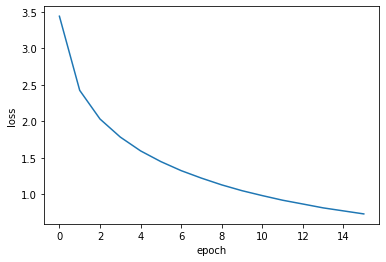

In [28]:
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")

In [29]:
len(test_data)

1000

In [30]:
score = bleu(test_data, net, german, english, device) * 100
print(f"Bleu Score: {score}")

Bleu Score: 32.21848885116025


In [31]:
# bleu score interpretation:
# 0 - 19: bad translations
# 20 - 29: understandable translations
# 30 - 39: good translations
# 40 - 49: High quality translations
# 50 - 60: Very high quality, adequate, and fluent translations
# > 60: Quality often better than human

In [32]:
text1 = "Ein Mann geht die Straße entlang, während er eine Tasse in der Hand hält"
og_translation1 = "a man is walking down the street while holding a cup"

In [33]:
pred_list = translate(net, text1, german, english, device)
pred_text = ""
for word in pred_list:
    pred_text += word + " "

print(pred_text)
print("")

a man is walking down the street holding a cup . <eos> 



In [34]:
text2 = "Dieser Affe klettert auf einen Baum"
og_translation2 = "that monkey is climbing a tree"

In [35]:
pred_list = translate(net, text2, german, english, device)
pred_text = ""
for word in pred_list:
    pred_text += word + " "

print(pred_text)
print("")

this mountain landscape are climbing a tree . <eos> 



In [36]:
text3 = "Dieser Mann rennt zu langsam, um den Bus zu erreichen"
og_translation3 = "that man is running too slow to catch the bus"

In [37]:
pred_list = translate(net, text3, german, english, device)
pred_text = ""
for word in pred_list:
    pred_text += word + " "

print(pred_text)
print("")

this man is running to make this bus to reach the bus . <eos> 

